PSNR: 54.74 dB


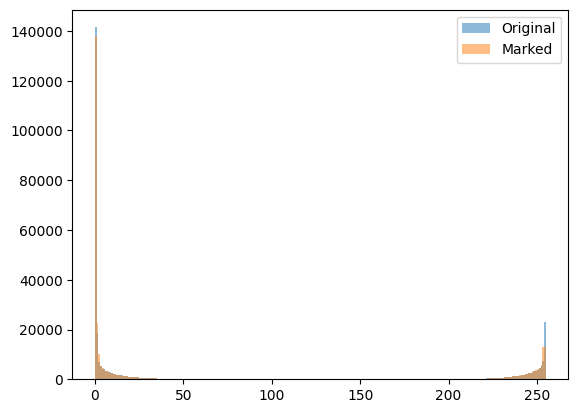

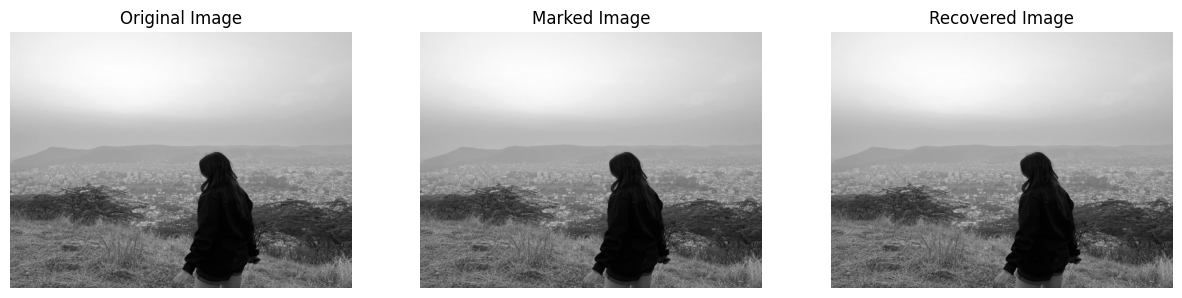

Extracted Data: 101010001010
Success: The extracted data matches the original data!


In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_index_map(n, delta, axis="columns"):
    index_map = np.zeros(n, dtype=int)
    flag = np.zeros(n, dtype=bool)
    index_map[0] = 0
    flag[0] = True
    for i in range(1, n):
        index_map[i] = (index_map[i - 1] + delta) % n
        if flag[index_map[i]]:
            index_map[i] = (index_map[i] + 1) % n
        flag[index_map[i]] = True
    return index_map

def psnr(original, marked):
    mse = np.mean((original - marked) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def custom_diff(arr, axis="columns"):

    if axis == "columns":
        cols = arr.shape[1]
        if cols % 2 != 0:
            raise ValueError("Odd number of columns")
        # difference of col0-col1, col2-col3, ...
        return arr[:, ::2] - arr[:, 1::2]
    else:
        rows = arr.shape[0]
        if rows % 2 != 0:
            raise ValueError("Odd number of rows")
        # difference of row0-row1, row2-row3, ...
        return arr[::2, :] - arr[1::2, :]

def find_optimal_delta(img, axis="columns"):

    if axis == "columns":
        size = img.shape[1]
    else:
        size = img.shape[0]

    max_capacity = 0
    optimal_delta = 1
    optimal_map = None

    for delta in range(1, size):
        index_map = generate_index_map(size, delta, axis=axis)
        transformed = img[:, index_map] if axis == "columns" else img[index_map, :]

        diff = custom_diff(transformed, axis)
        # Histogram in range [-256..256] => bins=513
        hist, _ = np.histogram(diff, bins=range(-256, 257))

        # Find the peak index from 256 upwards => only nonnegative diffs
        peak_idx = hist[256:].argmax()   # offset from 'diff == 0' bin
        capacity = hist[256 + peak_idx]  # how many diffs == peak_idx

        if capacity > max_capacity:
            max_capacity = capacity
            optimal_delta = delta
            optimal_map = index_map

    return optimal_delta, optimal_map, max_capacity

def embed_data(img, data, axis="columns"):


    delta, index_map, capacity = find_optimal_delta(img, axis)
    if len(data) > capacity:
        raise ValueError(f"Data too large. Max capacity: {capacity} bits")


    transformed = img[:, index_map] if axis == "columns" else img[index_map, :]
    diff = custom_diff(transformed, axis)


    hist, _ = np.histogram(diff, bins=range(-256, 257))
    peak_idx = hist[256:].argmax()
    peak_diff = peak_idx


    location_map = np.zeros_like(diff, dtype=bool)

    location_map[(diff >= 254)] = True
    location_map[(diff <= -255)] = True


    embedded = diff.copy()

    mask_up = (embedded > peak_diff) & (~location_map)
    embedded[mask_up] += 1



    data_idx = 0
    for i in range(embedded.shape[0]):
        for j in range(embedded.shape[1]):
            if data_idx >= len(data):
                break
            if location_map[i, j]:
                continue

            if embedded[i, j] == peak_diff:
                embedded[i, j] += int(data[data_idx])
                data_idx += 1


    new_data = embedded - diff
    num_rows, num_cols = new_data.shape

    if axis == "columns":
        new_array = np.zeros((num_rows, 2 * num_cols), dtype=new_data.dtype)
        new_array[:, ::2] = new_data
        marked = transformed + new_array
    else:
        new_array = np.zeros((2 * num_rows, num_cols), dtype=new_data.dtype)
        new_array[::2, :] = new_data
        marked = transformed + new_array


    inverse_map = np.argsort(index_map)
    if axis == "columns":
        marked_img = marked[:, inverse_map]
    else:
        marked_img = marked[inverse_map, :]

    return marked_img, delta, index_map, peak_diff, location_map

def extract_data(marked_img, delta, index_map, peak_diff, location_map, data_length, axis="columns"):


    transformed = marked_img[:, index_map] if axis == "columns" else marked_img[index_map, :]
    diff = custom_diff(transformed, axis)


    extracted_data = []
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if len(extracted_data) >= data_length:
                break
            if location_map[i, j]:
                continue


            if diff[i, j] == peak_diff + 1:
                extracted_data.append('1')
                diff[i, j] = peak_diff
            elif diff[i, j] == peak_diff:
                extracted_data.append('0')


        if len(extracted_data) == data_length:
            break

    extracted_data = ''.join(extracted_data)

    return extracted_data, transformed

def pdh_analysis(img, marked_img):
    diff_original = np.diff(img, axis=1)
    diff_marked = np.diff(marked_img, axis=1)
    plt.figure()
    plt.hist(diff_original.flatten(), bins=256, alpha=0.5, label='Original')
    plt.hist(diff_marked.flatten(), bins=256, alpha=0.5, label='Marked')
    plt.legend()
    plt.show()

def process(path, data, axis="columns"):
    img = np.array(Image.open(path).convert('L'))
    marked_img, delta, index_map, peak_diff, location_map = embed_data(img, data, axis)

    extracted_data, recovered_img = extract_data(
        marked_img, delta, index_map, peak_diff, location_map, len(data), axis
    )

    print(f"PSNR: {psnr(img, marked_img):.2f} dB")
    pdh_analysis(img, marked_img)


    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(marked_img, cmap='gray')
    ax[1].set_title('Marked Image')
    ax[1].axis('off')

    ax[2].imshow(recovered_img, cmap='gray')
    ax[2].set_title('Recovered Image')
    ax[2].axis('off')
    plt.show()


    print("Extracted Data:", extracted_data)


    if extracted_data == data:
        print("Success: The extracted data matches the original data!")
    else:
        print("Mismatch: Extracted data differs from the original data.")

    return marked_img, recovered_img


if __name__ == "__main__":
    path = "/content/011.jpg"
    data = "10101001010"
    marked_img, recovered_img = process(path, data, axis="columns")
